In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

2025-03-30 22:15:10.833544: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Directories
train_dir = "archive/train/"
test_dir = "archive/test"
valid_dir = 'archive/valid'


In [11]:
# Data Augmentation for Better Generalization
train_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    brightness_range=(0.7, 1.3),
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
)


In [12]:
test_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

val_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [13]:
# Load Data
train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

valid_data = val_gen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 2372 images belonging to 2 classes.
Found 675 images belonging to 2 classes.
Found 336 images belonging to 2 classes.


In [14]:
# Compute Class Weights for Imbalanced Data
class_weights = compute_class_weight('balanced', classes=np.unique(train_data.classes), y=train_data.classes)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}


In [15]:
# Model Building
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

In [16]:
# Freeze some early layers to retain pre-trained features
for layer in base_model.layers[:100]:
    layer.trainable = False

In [17]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [18]:
#  Early Stopping & ReduceLROnPlateau to Prevent Overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


In [19]:

# Training the Model
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)


/home/subarna/Downloads/Project8Sem/MajorProject/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.4962 - loss: 1.2926 - val_accuracy: 0.6489 - val_loss: 1.1020 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.5726 - loss: 1.1213 - val_accuracy: 0.4252 - val_loss: 1.1570 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.6137 - loss: 0.9799 - val_accuracy: 0.3985 - val_loss: 1.2027 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - accuracy: 0.5836 - loss: 0.8903 - val_accuracy: 0.4963 - val_loss: 0.9228 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.6154 - loss: 0.8189 - val_accuracy: 0.5363 - val_loss: 1.3224 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.6449 - loss: 0.7541 - val_accuracy: 0.6356 - val_loss: 0.7580 - learning_rate: 0.0010
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.6427 - loss: 0.7411 - val_acc

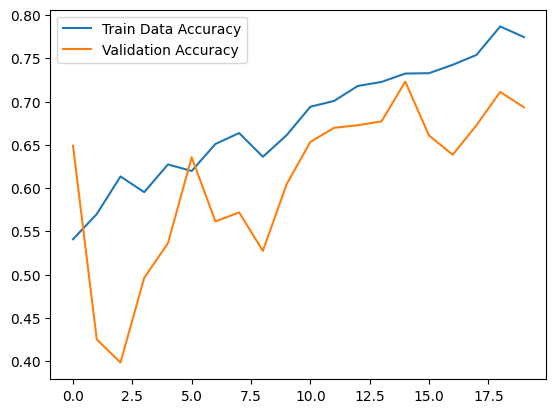

In [20]:
plt.plot(history.history['accuracy'], label = 'Train Data Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()

In [23]:
# Evaluate the Model
eval_results = model.evaluate(test_data)
print(f"Test Accuracy: {eval_results[1] * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 842ms/step - accuracy: 0.7109 - loss: 0.6069
Test Accuracy: 70.24%


In [24]:
y_scores = model.predict(test_data)
y_scores

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


array([[7.01758683e-01],
       [6.90321743e-01],
       [5.19691288e-01],
       [8.54504257e-02],
       [1.02011360e-01],
       [4.42668647e-02],
       [8.29051793e-01],
       [2.49589495e-02],
       [1.20024839e-02],
       [9.75473702e-01],
       [5.37056386e-01],
       [3.88121158e-01],
       [7.55810142e-01],
       [1.46649629e-02],
       [5.80750704e-02],
       [2.95334798e-03],
       [1.97870374e-01],
       [1.82795286e-01],
       [2.27548152e-01],
       [1.11746870e-01],
       [5.70439160e-01],
       [3.92237812e-01],
       [1.63070977e-01],
       [5.02994537e-01],
       [2.96792775e-01],
       [5.76499641e-01],
       [8.72965932e-01],
       [2.90557623e-01],
       [4.73466039e-01],
       [3.70658730e-04],
       [6.72709584e-01],
       [2.02433318e-01],
       [7.63664365e-01],
       [1.58714995e-01],
       [5.48503101e-01],
       [4.13440913e-02],
       [7.27627277e-01],
       [2.83278018e-01],
       [5.48195541e-01],
       [2.00918969e-02],


In [26]:
predictions = (model.predict(test_data) > 0.43).astype(int).flatten()
print(predictions)

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 832ms/step
[0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0
 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 1 1
 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0
 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1 1 1 1 1
 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 0
 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0
 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 0 0
 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 1 1
 1 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 1
 1 1 0]


In [27]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
import seaborn as sns

In [28]:
CLASS_NAMES = list(train_data.class_indices.keys())
predictions = (model.predict(test_data) > 0.49374890327453613).astype(int).flatten()
acc = accuracy_score(test_data.labels, predictions)
cm = tf.math.confusion_matrix(test_data.labels, predictions).numpy()
clr = classification_report(test_data.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 870ms/step
Test Accuracy: 51.488%


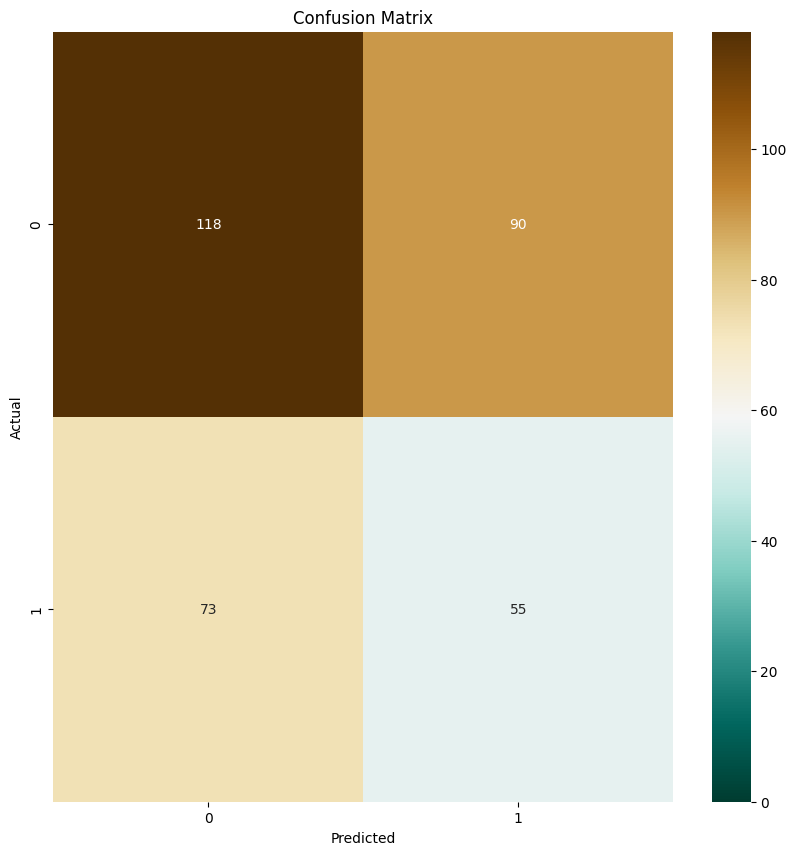

In [29]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True,fmt='d', vmin=0, cmap='BrBG_r', cbar=True)
plt.xticks(ticks= np.arange(2) + 0.5,)
plt.yticks(ticks= np.arange(2) + 0.5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [30]:
model.save('efficientnet_b0_model.keras')
